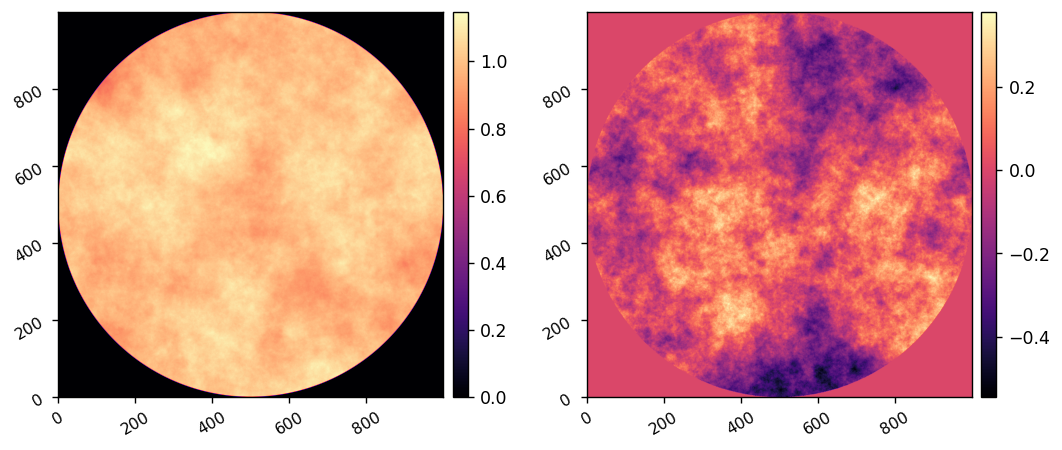

[[6.1084500e-07 6.1638375e-07 6.2192250e-07]
 [6.2746125e-07 6.3300000e-07 6.3853875e-07]
 [6.4407750e-07 6.4961625e-07 6.5515500e-07]]
[6.1638375e-07 6.3300000e-07 6.4961625e-07]


In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

import scoobpsf
import scoobpsf.scoob_rmad as rmad
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina
import lina.adefc_bb as adefc

wfe_amp = utils.load_fits('example_wfe_amp.fits')
wfe_phs = utils.load_fits('example_wfe_phs.fits')/2.5
WFE = wfe_amp * xp.exp(1j*wfe_phs)
imshow2(wfe_amp, wfe_phs)

Nwaves = 9
wavelength_c = 633e-9
bw = 0.07
waves = np.linspace(wavelength_c * (1-bw/2), wavelength_c * (1+bw/2), Nwaves )
bandpasses = waves.reshape(3,3)
print(bandpasses)

Nwaves_per_bp = bandpasses.shape[1]
est_waves = bandpasses[:, Nwaves_per_bp//2]
print(est_waves)

# Test the forward model parameters.

Oversampling > 2x suggested for reliable results in Fresnel propagation.


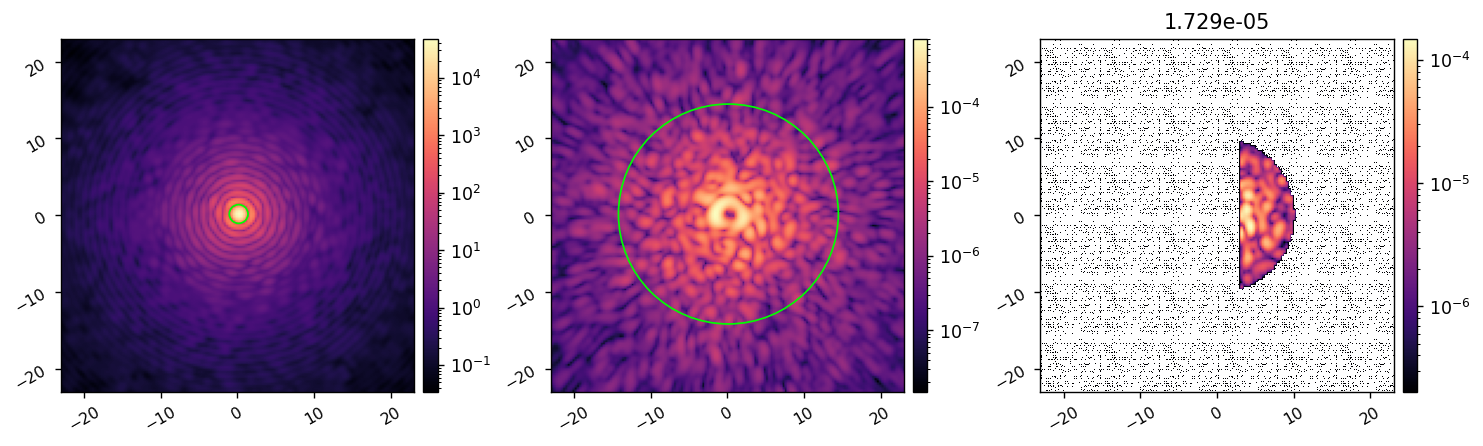

In [2]:
reload(rmad)
I = rmad.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    # dm_shift=np.array([0,0])*u.mm,
    # lyot_shift=np.array([0,0.3])*u.mm,
)
I.WFE = WFE
I.waves = waves

# I.reverse_lyot = 1
# I.flip_lyot = 1
# I.det_rotation = 178

I.setattr('use_vortex', False)
ref_psf = I.snap()
I.setattr('Imax_ref', xp.max(ref_psf))
I.setattr('use_vortex', True)
ref_coro_im = I.snap()

iwa = 3
owa = 10
rot = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=iwa, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

psf_center = (I.psf_pixelscale_lamDc/2, I.psf_pixelscale_lamDc/2)
imshow3(ref_psf, ref_coro_im, ref_coro_im*control_mask, '', '', f'{mean_ni:.3e}',
        lognorm=True, pxscl=I.psf_pixelscale_lamDc, 
        patches1=[Circle(psf_center, 1.22, fill=False, color='lime')], 
        patches2=[Circle(psf_center, I.control_rad, fill=False, color='lime')])


Oversampling > 2x suggested for reliable results in Fresnel propagation.


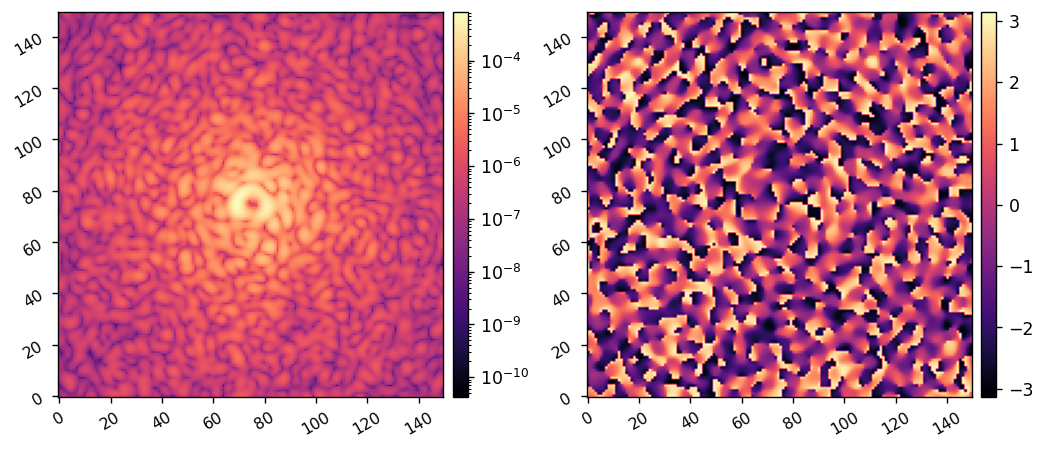

In [3]:
reload(rmad)
reload(scoobpsf.dm)
M = rmad.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    # dm_shift=np.array([0,0])*u.mm,
    # lyot_shift=np.array([0,0.3])*u.mm,
)
M.WFE = WFE

# M.reverse_lyot = 1
# M.flip_lyot = 1
# M.det_rotation = 178

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

fpwf = M.forward(xp.zeros(M.dm_shape)[M.dm_mask], use_vortex=True)
imshow2(xp.abs(fpwf)**2, xp.angle(fpwf), lognorm1=True)



In [4]:
I.zero_dm()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'commands':[],
    'del_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

In [27]:
bandpasses[:, 3//2], bandpasses

(<Quantity [6.092625e-07, 6.330000e-07, 6.567375e-07] m>,
 <Quantity [[6.013500e-07, 6.092625e-07, 6.171750e-07],
            [6.250875e-07, 6.330000e-07, 6.409125e-07],
            [6.488250e-07, 6.567375e-07, 6.646500e-07]] m>)

Running estimation algorithm ...
Computing EFC command with L-BFGS


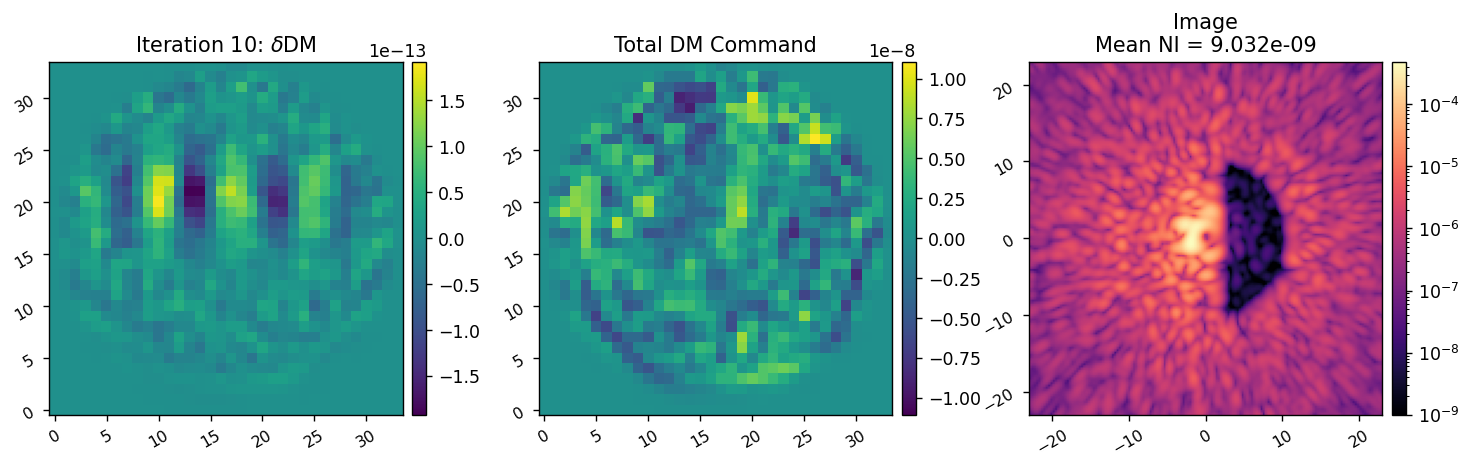

Running estimation algorithm ...
Computing EFC command with L-BFGS


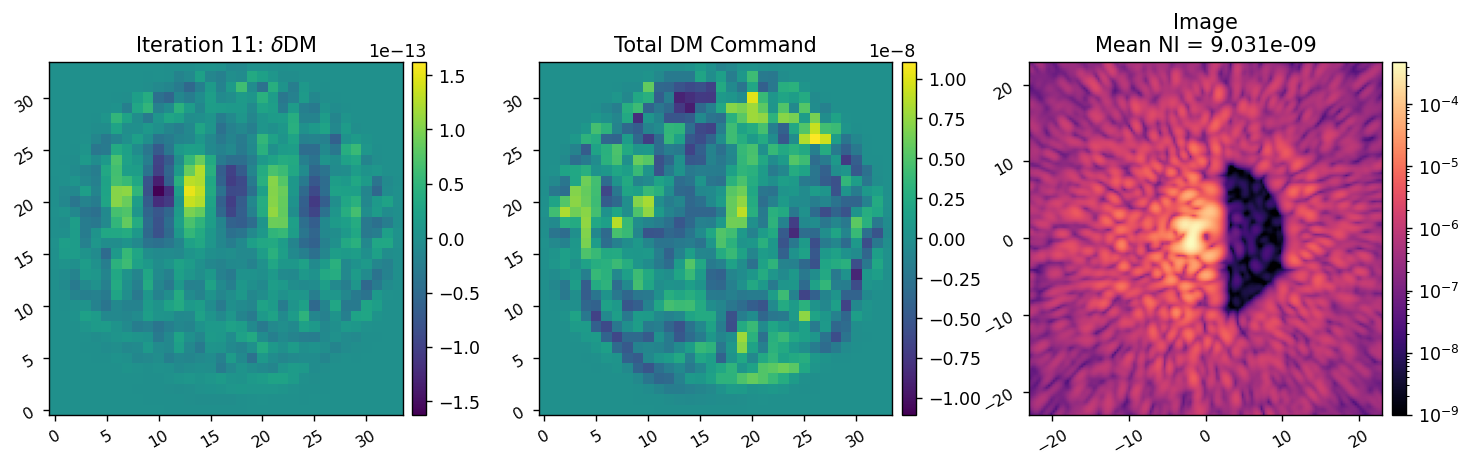

Running estimation algorithm ...
Computing EFC command with L-BFGS


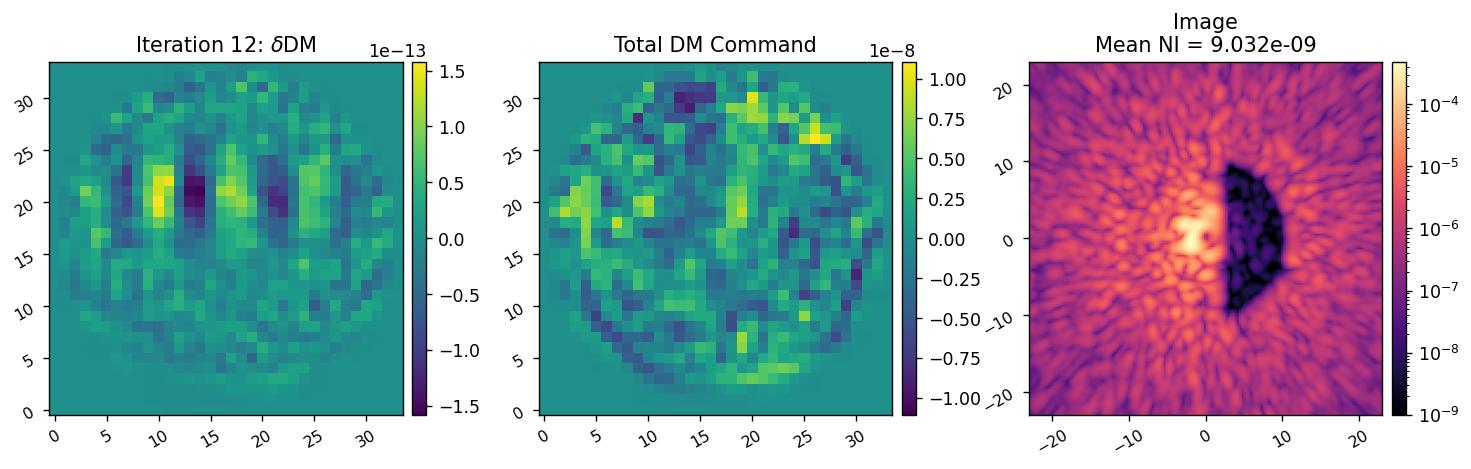

In [8]:
reload(rmad)
reload(adefc)
reload(lina.utils)

r_cond = 1e-1
r_cond = 1e-2
# r_cond = 1e-3
# r_cond = 1e-4
# r_cond = 1e-5
# r_cond = 1e-6

bfgs_tol = 1e-2
# bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':False,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

data = adefc.run(I, M, 
                 rmad.val_and_grad_bb, 
                 control_mask, 
                 bandpasses, 
                 data,
                #  pwp_params=pwp_params, 
                 Nitr=3, 
                 reg_cond=r_cond,
                 bfgs_tol=bfgs_tol,
                 bfgs_opts=bfgs_opts,
                 gain=1,
                 )

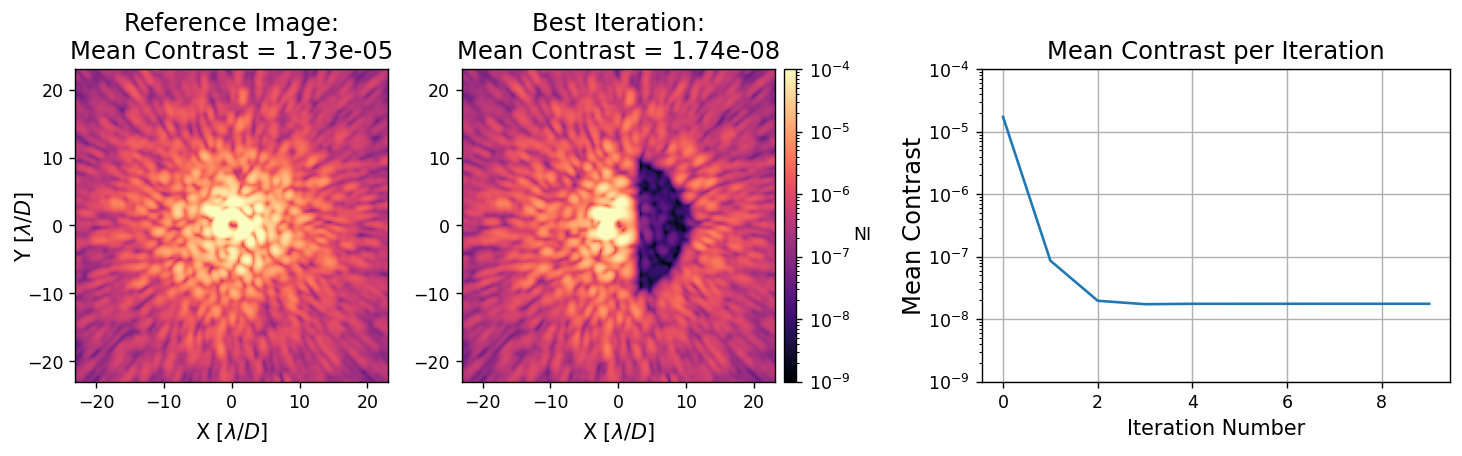

In [10]:

reload(adefc)
adefc.plot_data(data)
